- 테이블 페이지의 힙 튜플은 일반 데이터 튜플과 TOAST 튜플의 두 가지 유형으로 분류

- 힙 튜플은 HeapTupleHeaderData 구조, NULL 비트맵 및 사용자 데이터의 세 부분으로 구성

**튜플 구조.**

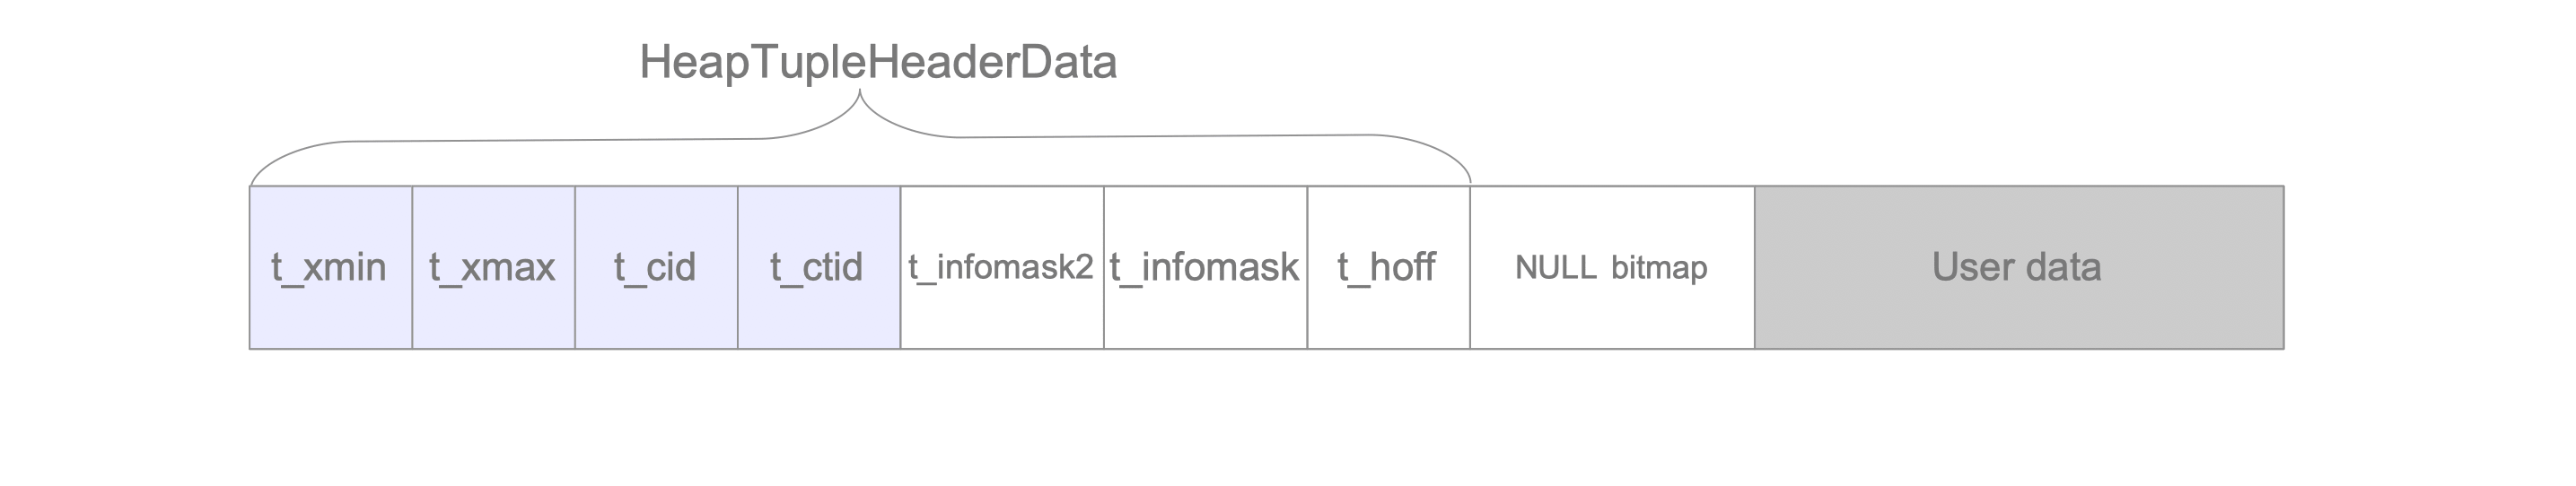

- HeapTupleHeaderData구조체에는 7개의 필드가 포함되어 있지만 후속 섹션에서는 그 중 4개만 필요.

- t_xmin은 이 튜플을 삽입한 트랜잭션의 txid를 보유.

- t_xmax는 이 튜플을 삭제하거나 업데이트한 트랜잭션의 txid를 보유.

- 이 튜플이 삭제되거나 업데이트되지 않은 경우 t_xmax는 0으로 설정되며 이는 INVALID를 의미.

- t_cid는 0부터 시작하여 현재 트랜잭션 내에서 이 명령이 실행되기 전에 실행된 SQL 명령의 수인 명령 id(cid)를 보유.
  - 예를 들어 단일 트랜잭션 내에서 3개의 INSERT 명령을 실행한다고 가정.
  - 'BEGIN ; 끼워 넣다; 끼워 넣다; 끼워 넣다; 저지르다;'. 첫 번째 명령이 이 튜플을 삽입하면 t_cid는 0으로 설정.
  - 두 번째 명령이 이 튜플을 삽입하면 t_cid는 1로 설정되는 식.

- t_ctid는 자신 또는 새 튜플을 가리키는 튜플 식별자(tid)를 보유
  - tid는 테이블 내의 튜플을 식별하는 데 사용.
  - 이 튜플이 업데이트되면 이 튜플의 t_ctid가 새 튜플을 가리킵니다. 그렇지 않으면 t_ctid가 자신을 가리킴.

**HeapTupleHeaderData**

```
typedef struct HeapTupleFields
{
        TransactionId t_xmin;		   /* inserting xact ID */
        TransactionId t_xmax;              /* deleting or locking xact ID */

        union
        {
                CommandId       t_cid;     /* inserting or deleting command ID, or both */
                TransactionId 	t_xvac;    /* old-style VACUUM FULL xact ID */
        } t_field3;
} HeapTupleFields;

typedef struct DatumTupleFields
{
        int32          datum_len_;          /* varlena header (do not touch directly!) */
        int32          datum_typmod;   	    /* -1, or identifier of a record type */
        Oid            datum_typeid;   	    /* composite type OID, or RECORDOID */

        /*                                                                                               
         * Note: field ordering is chosen with thought that Oid might someday                            
         * widen to 64 bits.                                                                             
         */
} DatumTupleFields;

typedef struct HeapTupleHeaderData
{
        union
        {
                HeapTupleFields t_heap;
                DatumTupleFields t_datum;
        } t_choice;

        ItemPointerData t_ctid;         /* current TID of this or newer tuple */

        /* Fields below here must match MinimalTupleData! */
        uint16          t_infomask2;    /* number of attributes + various flags */
        uint16          t_infomask;     /* various flag bits, see below */
        uint8           t_hoff;         /* sizeof header incl. bitmap, padding */
        /* ^ - 23 bytes - ^ */
        bits8           t_bits[1];      /* bitmap of NULLs -- VARIABLE LENGTH */

        /* MORE DATA FOLLOWS AT END OF STRUCT */
} HeapTupleHeaderData;

typedef HeapTupleHeaderData *HeapTupleHeader;
```